In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
try:
    import empyrical as emp
except:
    emp = None
import tushare as ts
import time
import random

from common.log import *
from common.config import Config
from spider.spider_nasdaq import Spider_nasdaq
from spider.spider_coinmarketcap import Spider_coinmarketcap

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from pandas_highcharts.core import serialize
from pandas_highcharts.display import display_charts

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

CONF = Config('../conf/secret.yaml').data[0]
ts_token = CONF['TUSHARE']['TOKEN']
ts.set_token(ts_token)
pro = ts.pro_api()

CONF = Config().data[0]
MONGODB = CONF['MONGODB']
NASDAQ = CONF['NASDAQ']
CRYPTOCURRENCY = CONF['CRYPTOCURRENCY']
CRYPTOCURRENCY = list(CRYPTOCURRENCY.keys())
NASDAQ100 = CONF['NASDAQ100']

MONITOR_TARGET = {
    '399300': {'MA': [17], 'ROLLINGMAX': [], 'ROLLINGMIN': [], 'N': 10, 'NAME': '沪深300(SZ:399300)'},
    '000905': {'MA': [17], 'ROLLINGMAX': [], 'ROLLINGMIN': [], 'N': 10, 'NAME': '中证500(SH:000905)'},
    '399006': {'MA': [17], 'ROLLINGMAX': [], 'ROLLINGMIN': [], 'N': 10, 'NAME': '创业板指(SZ:399006)'},
    'BITCOIN': {'MA': [5], 'ROLLINGMAX': [], 'ROLLINGMIN': [], 'N': 2, 'NAME': 'BITCOIN'},
    'EOS': {'MA': [5], 'ROLLINGMAX': [], 'ROLLINGMIN': [], 'N': 2, 'NAME': 'EOS'},
    'ETHEREUM': {'MA': [5], 'ROLLINGMAX': [], 'ROLLINGMIN': [], 'N': 2, 'NAME': 'ETHEREUM'},
    'RIPPLE': {'MA': [5], 'ROLLINGMAX': [], 'ROLLINGMIN': [], 'N': 2, 'NAME': 'RIPPLE'},
    'LITECOIN': {'MA': [5], 'ROLLINGMAX': [], 'ROLLINGMIN': [], 'N': 2, 'NAME': 'LITECOIN'},
}

pd

<module 'pandas' from 'd:\\python3\\lib\\site-packages\\pandas\\__init__.py'>

In [2]:
%%time

IS_DOWNLOAD_DATA = False

spider_n = Spider_nasdaq()
spider_c = Spider_coinmarketcap()

for symbol in MONITOR_TARGET:
    if not IS_DOWNLOAD_DATA:
        break
        
    print(symbol)

    # 指数
    if symbol in ['399300', '000905', '000016', '399006']:
        df = ts.get_k_data(code=symbol, index=True, start='2005-01-01', end=time.strftime('%Y-%m-%d'))
        datafile = '../database/market/%s.csv' % symbol
        df.to_csv(datafile, index=False, encoding='utf-8')
        
    # CRYPTOCURRENCY
    elif symbol in CRYPTOCURRENCY:
        datafile = spider_c.get_coin_data(symbol, start_date='20100101', end_date=time.strftime('%Y%m%d'))
        
    # ETF
    else:
        df = ts.get_k_data(code=symbol, ktype='D', autype='qfq', index=False, start='2005-01-01', end=time.strftime('%Y-%m-%d'))
        datafile = '../database/market/%s.csv' % symbol
        df.to_csv(datafile, index=False, encoding='utf-8')
        time.sleep(1)

    time.sleep(1)

Wall time: 0 ns


In [3]:
%%time

stock_df_dict = {}

for symbol in MONITOR_TARGET:
    stock_data_file = '../database/market/%s.csv' % symbol
    if symbol in CRYPTOCURRENCY:
        stock_data_file = '../database/market/%s_OKEX.csv' % symbol
    try:
        stock_df = pd.read_csv(stock_data_file)
    except:
        print(symbol)
        continue

    # 筛选字段
#     stock_df = stock_df.loc[:, ['date', 'open', 'close']]
    stock_df = stock_df.loc[:, ['date', 'close']]

    # 去掉Nasdaq行情首行的当天行情
    if symbol in NASDAQ100:
        stock_df = stock_df.drop([0])

    # 抛弃空值异常值
    stock_df.dropna(axis=0, how='any', inplace=True)

    # 格式化日期
    # 445 ms ± 17.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    stock_df = stock_df.assign(date=pd.to_datetime(stock_df['date']))  # need .index.to_period('D')

    # 用日期作索引，日期升序排序
    # 95.1 µs ± 1.58 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
    if symbol in NASDAQ100 or symbol in CRYPTOCURRENCY:
        stock_df = stock_df[1:]
        stock_df = stock_df[::-1]
    stock_df.set_index(['date'], inplace=True)
    stock_df.index = stock_df.index.to_period('D')

    # 计算每天涨跌幅
    N = MONITOR_TARGET[symbol]['N']
    stock_df['N_sht'] = stock_df.close.shift(N-1)
    stock_df['N_chg'] = (stock_df.close.shift(0) - stock_df.close.shift(N-1)) / stock_df.close.shift(N-1)

    for MA_PARAM in MONITOR_TARGET[symbol]['MA']:
        stock_df['MA_%d' % MA_PARAM] = stock_df['close'].rolling(MA_PARAM).mean()
    
    for ROLLINGMAX_PARAM in MONITOR_TARGET[symbol]['ROLLINGMAX']:
        stock_df['ROLLINGMAX_%d' % ROLLINGMAX_PARAM] = stock_df['close'].rolling(ROLLINGMAX_PARAM).max()
        
    for ROLLINGMIN_PARAM in MONITOR_TARGET[symbol]['ROLLINGMIN']:
        stock_df['ROLLINGMIN_%d' % ROLLINGMIN_PARAM] = stock_df['close'].rolling(ROLLINGMIN_PARAM).min()
    
    # 减少数据
    # stock_df = stock_df['2016-01-01':]
    stock_df.dropna(how='any', inplace=True)
    
    stock_df_dict[symbol] = stock_df

Wall time: 295 ms


In [4]:
%store MONITOR_TARGET
%store stock_df_dict

Stored 'MONITOR_TARGET' (dict)
Stored 'stock_df_dict' (dict)


In [5]:
for symbol in MONITOR_TARGET:
    symbol
    stock_df_dict[symbol].tail(3)

'399300'

,close,N_sht,N_chg,MA_17
date,,,,
2019-05-30,3641.18,3648.76,-0.002077,3656.333529
2019-05-31,3629.79,3617.79,0.003317,3654.117647
2019-06-03,3632.01,3666.78,-0.009482,3656.018235


'000905'

,close,N_sht,N_chg,MA_17
date,,,,
2019-05-30,4926.40,4942.58,-0.003274,4966.216471
2019-05-31,4912.00,4923.56,-0.002348,4964.114118
2019-06-03,4853.82,5009.87,-0.031149,4962.079412


'399006'

,close,N_sht,N_chg,MA_17
date,,,,
2019-05-30,1485.24,1478.75,0.004389,1491.228235
2019-05-31,1483.66,1469.31,0.009766,1491.333529
2019-06-03,1468.98,1493.72,-0.016563,1491.304118


'BITCOIN'

,close,N_sht,N_chg,MA_5
date,,,,
2019-05-30,8348.4,8928.7,-0.064993,8688.84
2019-05-31,8528.8,8348.4,0.021609,8635.00
2019-06-01,8679.3,8528.8,0.017646,8633.58


'EOS'

,close,N_sht,N_chg,MA_5
date,,,,
2019-05-30,7.781,8.329,-0.065794,7.930
2019-05-31,8.189,7.781,0.052435,8.082
2019-06-01,7.700,8.189,-0.059714,8.030


'ETHEREUM'

,close,N_sht,N_chg,MA_5
date,,,,
2019-05-30,257.64,286.65,-0.101204,271.210
2019-05-31,265.68,257.64,0.031206,270.500
2019-06-01,267.78,265.68,0.007904,269.902


'RIPPLE'

,close,N_sht,N_chg,MA_5
date,,,,
2019-05-30,0.4207,0.4700,-0.104894,0.44108
2019-05-31,0.4281,0.4207,0.017590,0.44216
2019-06-01,0.4381,0.4281,0.023359,0.44100


'LITECOIN'

,close,N_sht,N_chg,MA_5
date,,,,
2019-05-30,108.75,119.05,-0.086518,115.144
2019-05-31,112.74,108.75,0.036690,114.302
2019-06-01,113.71,112.74,0.008604,114.238


,SYMBOL,DATE,NOW,BUY,BUYDIFF,SELL,SELLDIFF,MA,MADIFF,N_chg,N_sht
0,399300,2019-06-03,3632.0100,NaN,NaN,NaN,NaN,3656.018235,-0.66%,-0.95%,3666.7800
1,000905,2019-06-03,4853.8200,NaN,NaN,NaN,NaN,4962.079412,-2.23%,-3.11%,5009.8700
2,399006,2019-06-03,1468.9800,NaN,NaN,NaN,NaN,1491.304118,-1.52%,-1.66%,1493.7200
3,BITCOIN,2019-06-01,8679.3000,NaN,NaN,NaN,NaN,8633.580000,0.53%,1.76%,8528.8000
4,EOS,2019-06-01,7.7000,NaN,NaN,NaN,NaN,8.030000,-4.29%,-5.97%,8.1890
5,ETHEREUM,2019-06-01,267.7800,NaN,NaN,NaN,NaN,269.902000,-0.79%,0.79%,265.6800
6,RIPPLE,2019-06-01,0.4381,NaN,NaN,NaN,NaN,0.441000,-0.66%,2.34%,0.4281
7,LITECOIN,2019-06-01,113.7100,NaN,NaN,NaN,NaN,114.238000,-0.46%,0.86%,112.7400


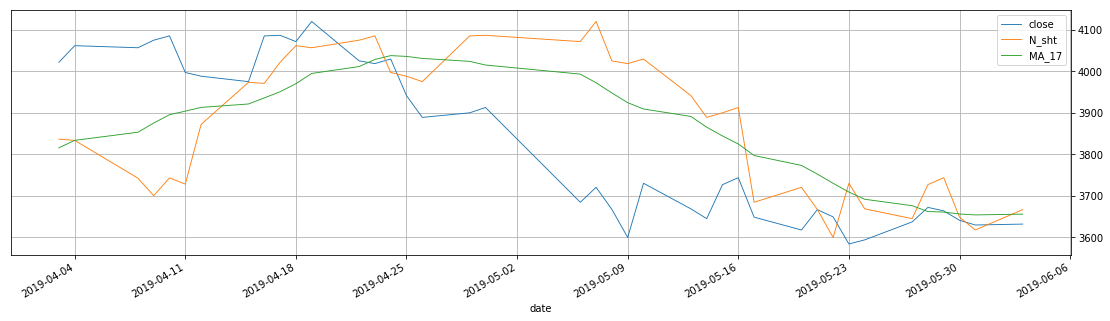

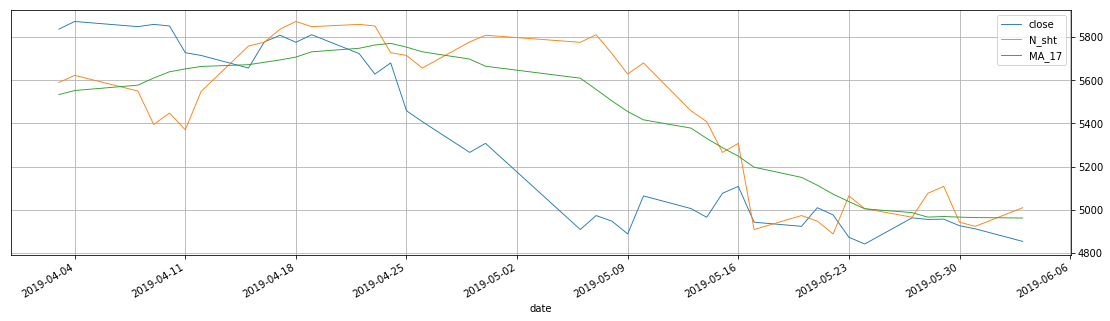

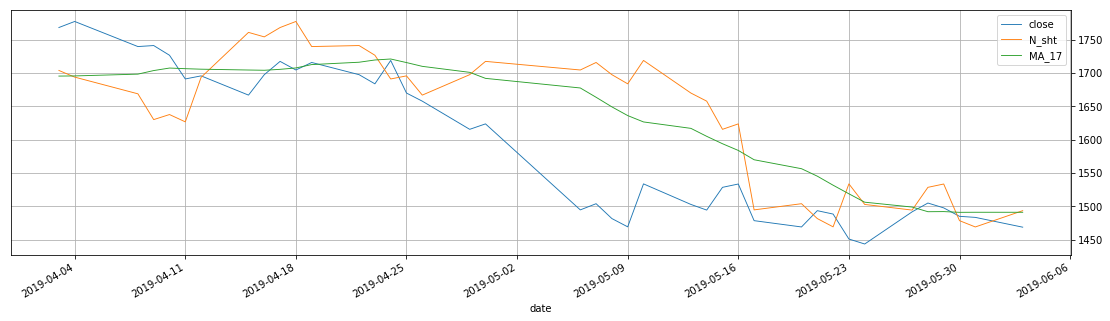

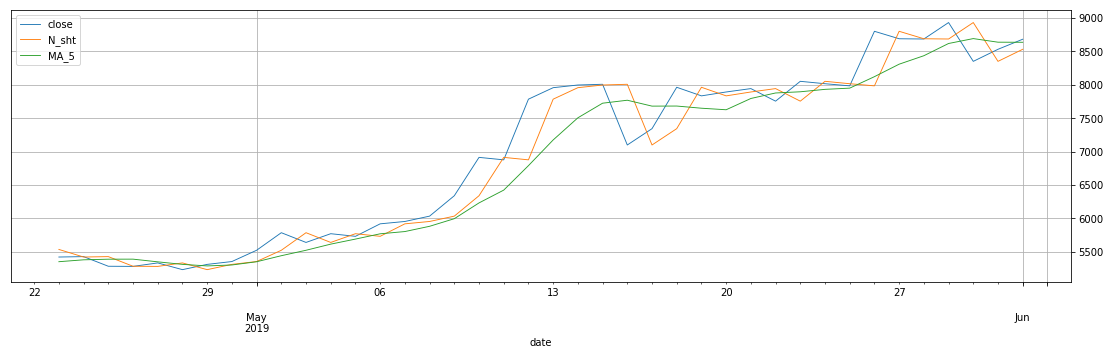

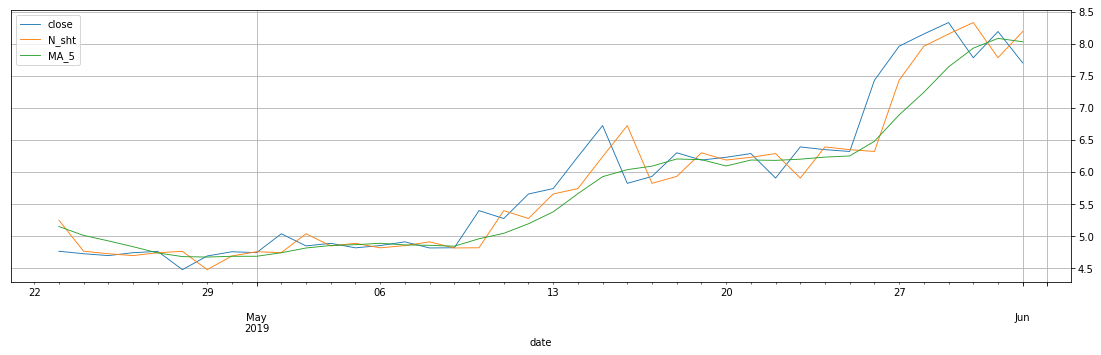

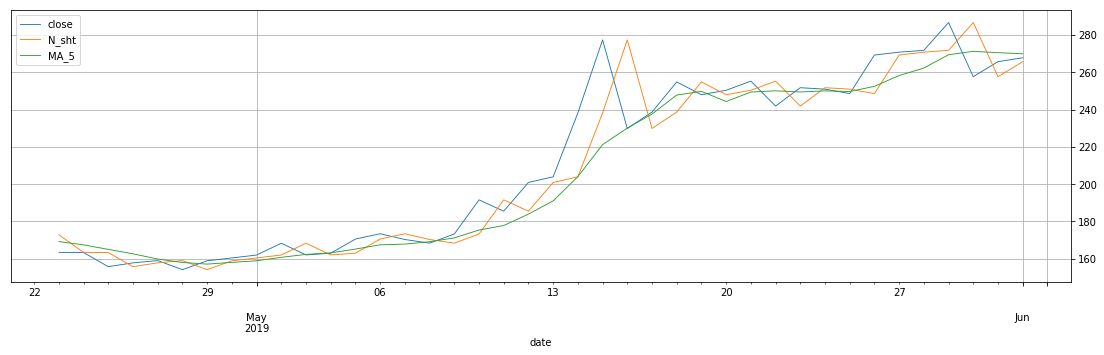

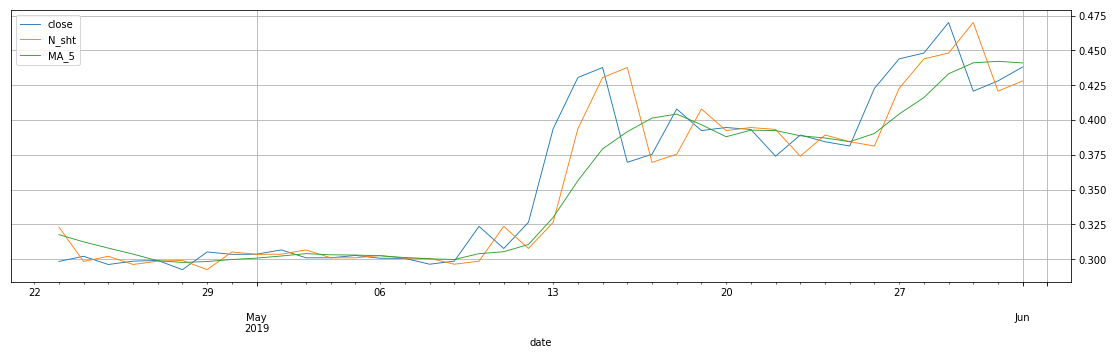

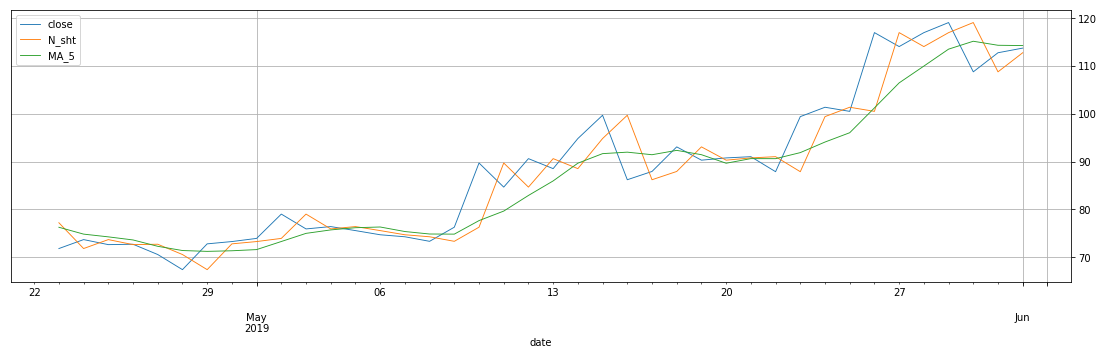

In [6]:
monitor_df = pd.DataFrame(columns=['SYMBOL', 'DATE', 'NOW', 'BUY', 'BUYDIFF', 'SELL', 'SELLDIFF'])

for symbol in MONITOR_TARGET:
    df = stock_df_dict[symbol].iloc[-40:].copy()
    
    df.reset_index(drop=False, inplace=True)
    # df = df.astype(dtype={'date': 'datetime64[ns]'})
    df['date'] = df['date'].apply(lambda x: x.to_timestamp().to_datetime64())
    df.set_index('date', inplace=True)
    
    today_market = df.iloc[-1]
    now_point = today_market.close
    for col in df.columns:
        if 'ROLLINGMAX' in col:
            buy_point = today_market[col]
            buy_diff = (buy_point - now_point) / now_point * 100
        elif 'ROLLINGMIN' in col:
            sell_point = today_market[col]
            sell_diff = (now_point - sell_point) / now_point * 100
        elif 'MA' in col:
            ma = today_market[col]
            ma_diff = (now_point - ma) / now_point * 100
        elif 'N_chg' in col:
            n_chg = today_market[col] * 100
    
    monitor_df = monitor_df.append({
        'SYMBOL': symbol, 
        'DATE': today_market.name.date(), 
        'NOW': now_point, 
#         'BUY': buy_point, 
#         'BUYDIFF': '+%.2f%%' % buy_diff, 
#         'SELL': sell_point, 
#         'SELLDIFF': '-%.2f%%' % sell_diff,
        'MA': ma,
        'MADIFF': '%.2f%%' % ma_diff,
        'N_sht': today_market.N_sht, 
        'N_chg': '%.2f%%' % n_chg,
    }, ignore_index=True)
    
    title = ''
#     title = '%s, %s, close=%.1f, buy=%.1f(+%.1f%%), sell=%.1f(-%.1f%%)' % \
#         (symbol, today_market.name.date(), now_point, buy_point, buy_diff, sell_point, sell_diff)
    
    df.drop(columns=['N_chg'], inplace=True)
    ax = df.plot(kind='line', title=title, linewidth=0.9, grid=True, figsize=(19, 5))
    ax.yaxis.tick_right()
    
#     display_charts(df, chart_type='stock', kind='line', title=title, figsize=(1000, 600))


monitor_df

In [7]:
# df = ts.get_realtime_quotes(['sh', 'sz', 'hs300', 'sz50', 'sh000905', 'zxb', 'cyb'])
# df = ts.get_realtime_quotes(['hs300', 'sh000905', 'cyb'])
# df = ts.get_realtime_quotes(list(MONITOR_TARGET.keys()))
# df
# list(MONITOR_TARGET.keys())